In [15]:
from sklearn.datasets import load_iris
from sklearn import tree
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [18]:
%matplotlib inline

In [3]:
iris = load_iris()
clf = tree.DecisionTreeClassifier()
clf.fit(iris.data, iris.target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

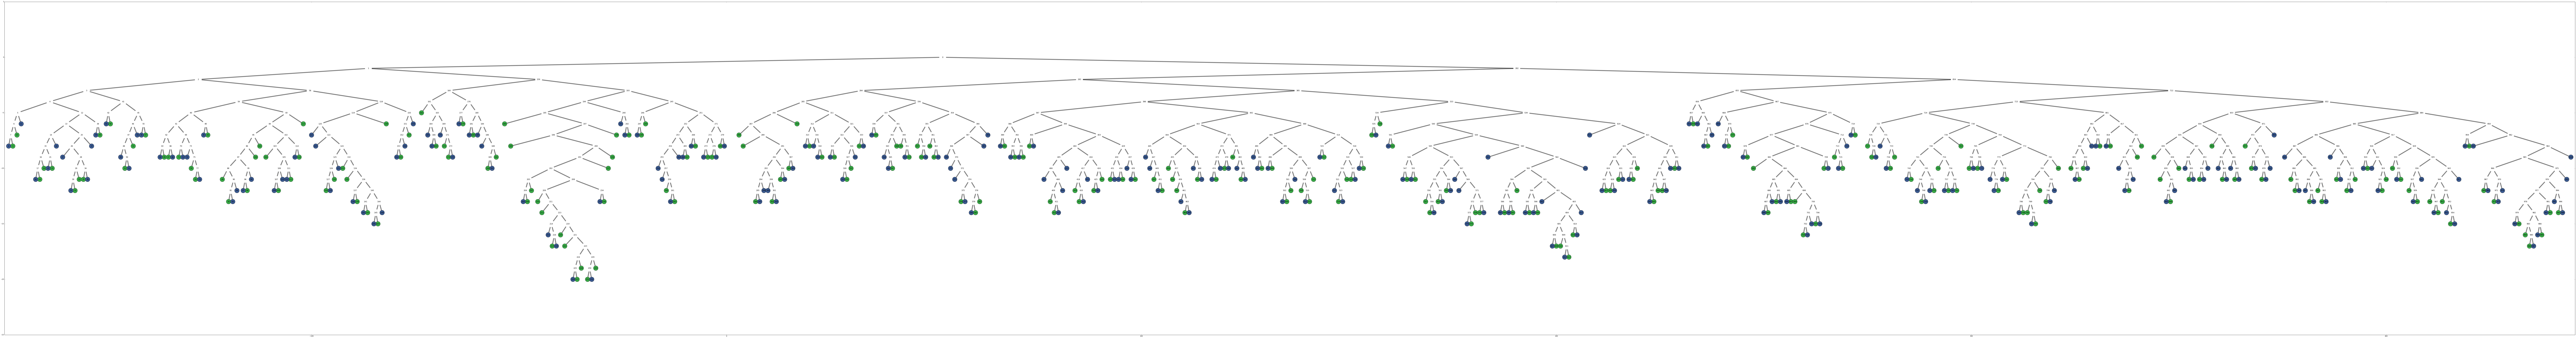

In [89]:
class tree_plot:
    '''
    class to plot decision tree
    this only works for binary trees right now
    '''
    def __init__(self, clf):
        self.tree = clf.tree_
        self.tree_map = {}
        self.left = self.tree.children_left
        self.right = self.tree.children_right
        self.clf = clf
        
        self.layers = set()
        self.map_init()
        # self.x_relative(0)
        
        
        # don't need to find x value for top layer
        for l in sorted(self.layers)[:-1]:
            node_list = filter(lambda n: self.tree_map[n]['y'] == l,
                               self.tree_map)
            for node in node_list:
                self.tree_map[node]['x'] = self.bottom_up(node)
                
        self.x_abs(0)
                                 
        for l in sorted(self.layers):
            node_list = filter(lambda n: self.tree_map[n]['y'] == l,
                               self.tree_map)
            for node in node_list:
                self.center(node)
                
        
        
    def map_init(self, node = 0, y = 0, parent = None,
                 l_outer = True, r_outer = True):
        '''
        calcualte y values for nodes based on the tree layer
        note: recursive function
        '''
        self.layers.add(y)

        # check for terminal node
        if self.left[node] == -1:
            self.tree_map[node] = {
                'y':y,
                'x':0,
                'parent':parent,
                'l_outer':l_outer,
                'r_outer':r_outer,
            }
        else:
            self.tree_map[node] = {
                'y':y,
                'x':0,
                'parent':parent,
                'l_outer':l_outer,
                'r_outer':r_outer,
                
                'r_child':self.right[node],
                'l_child':self.left[node],
            }
            
            self.map_init(node = self.right[node], y = y-1,
                          parent = node, l_outer = False, r_outer = r_outer)
            self.map_init(node = self.left[node], y = y-1,
                          parent = node, l_outer = l_outer, r_outer = False)
            
            
    def bottom_up(self, node):
        # find direction of node from parent
        p = self.tree_map[node]['parent']
        if self.tree_map[p]['l_child'] == node:
            direction = -1
        else:
            direction = 1
        # if node is terminal return 0.5 distance
        if self.left[node] == -1:
            self.tree_map[node]['r_dist'] = 0
            self.tree_map[node]['l_dist'] = 0
            return 0.5 * direction
            
        l_child = self.tree_map[self.tree_map[node]['l_child']]
        r_child = self.tree_map[self.tree_map[node]['r_child']]

        self.tree_map[node]['r_dist'] = max(
            (r_child['r_dist'] + r_child['x']),
            # remember the left child has a negative x
            (l_child['r_dist'] + l_child['x']))
            
        self.tree_map[node]['l_dist'] = 0.5 + max(
            (r_child['l_dist'] - r_child['x']),
            # remember the left child has a negative x
            (l_child['l_dist'] - l_child['x']))    
                                        
        if direction == -1:
            return sum([0.5, self.tree_map[self.right[node]]['x'],
                       r_child['r_dist']]) * -1
  
        else:
            return sum([-0.5, self.tree_map[self.left[node]]['x'],
                       -l_child['l_dist']]) * -1
        

    def x_abs(self, node = 0, x = 0):
        '''
        sums the relative x position to find absolute x position
        '''
        x += self.tree_map[node]['x']
        self.tree_map[node]['x_abs'] = x 
        
        if self.left[node] == -1:
            return
        
        self.x_abs(self.right[node], x)
        self.x_abs(self.left[node], x)
        
    def center(self, node):
        '''
        center a node between its children
        '''
        # if node is terminal do nothing
        if self.left[node] == -1:
            return
        left = self.tree_map[self.left[node]]['x_abs']
        right = self.tree_map[self.right[node]]['x_abs']
        self.tree_map[node]['x_abs'] = (left + right)/2.0
        
    
    def plot(self, feature_names, round_n = 2,
             colors = ['#39ad48', '#3b5b92']):
        '''
        actual plot function
        '''
        # find appropriate dimensions for the plot
        x_max = max(self.tree_map[n]['x_abs'] for n in self.tree_map)
        x_min = min(self.tree_map[n]['x_abs'] for n in self.tree_map)
        x_size = x_max - x_min
        y_size = max(abs(self.tree_map[n]['y']) for n in self.tree_map)
        plt.figure(figsize = (x_size/2, y_size*2))
        # initialize networkx plot
        G = nx.Graph()
        # add edges
        for i,n in enumerate(self.left):
            if n != -1:
                G.add_edge(i,n,weight=1)
        for i,n in enumerate(self.right):
            if n != -1:
                G.add_edge(i,n,weight=1)

        labels = {}
        white_nodes = []
        colored_nodes_0 = []
        colored_nodes_1 = []
        # node lables
        for i,j in enumerate(self.tree.feature):
            # if node is a decision it should be white
            if j != -2:
                labels[i] = str(feature_names[j]) + '\n'
                labels[i] +='>=' + str(np.round(self.tree.threshold[i],round_n))
                white_nodes.append(i)
            # if node is terminal it should be colored
            # only works for binary decision trees
            elif np.argmax(self.tree.value[i]) == 0:
                labels[i] = np.argmax(self.tree.value[i])
                colored_nodes_0.append(i)
            else:
                labels[i] = np.argmax(self.tree.value[i])
                colored_nodes_1.append(i)
        # build location map for nodes
        pos = {int(i):(self.tree_map[i]['x_abs'], self.tree_map[i]['y'])
               for i in xrange(len(self.tree_map))}

        # draw nodes
        nodes = nx.draw_networkx_nodes(G,pos, nodelist = white_nodes,
                                       node_color = '#FFFFFF',
                                       node_size=2000, node_shape = 'o')
        # remove decision node borders
        nodes.set_edgecolor('#FFFFFF')
        # add colored nodes
        nx.draw_networkx_nodes(G,pos, nodelist = colored_nodes_0,
                               node_size=1000, node_color = colors[0])
        nx.draw_networkx_nodes(G,pos, nodelist = colored_nodes_1,
                       node_size=1000, node_color = colors[1])
        # draw edges
        nx.draw_networkx_edges(G,pos,alpha=0.5,width=6)
        # add lables
        # nx.draw_networkx_labels(G,pos,labels,font_size=12,
        #                         font_family='sans-serif')
        nx.draw_networkx_labels(G,pos,font_size=12,
                                font_family='sans-serif')
#         plt.axis('off')
        plt.xlim(min(pos[x][0] for x in pos)-1, max(pos[x][0] for x in pos)+1)
        plt.show()
        
            
my_tree = tree_plot(clf)
my_tree.plot(range(len(X)))


In [88]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=5000,
                           n_features=20,
                           n_informative=20,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=2,
                           random_state=0,
                           shuffle=False)

clf = tree.DecisionTreeClassifier()#max_depth = 10)
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')